<a href="https://colab.research.google.com/github/jcvancity2022/NLP-Week1-Text-Classification/blob/main/true_fake_news_classifier60DatasetIMPROVEMENT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake News Detection Using DistilBERT
This project fine-tunes a DistilBERT model to classify news articles
as Fake (0) or Real (1). We combined multiple public misinformation
datasets and trained a binary classifier using HuggingFace Transformers.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup Python Libraries (pip)

In [ ]:
#install some Python packages with pip

!pip install numpy torch datasets transformers evaluate --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
# let's check the version we are using

!pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==4.0.0
evaluate==0.4.6
numpy==2.0.2
torch==2.9.0+cu126
torchao==0.10.0
torchaudio==2.9.0+cu126
torchdata==0.11.0
torchsummary==1.5.1
torchtune==0.6.1
torchvision==0.24.0+cu126
transformers==4.57.2


# Create IMDB Dataset for Fine-tuning BERT

In [ ]:
class_labels = {
    0: "Fake",
    1: "Real"
}


## Let's load the IMDB Dataset

fake-and-real-news-dataset

Fake News Detection

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict

# ---------------------------------------------------------------
# 1. Load Fake News Detection Dataset
# ---------------------------------------------------------------
df_fake1 = pd.read_csv("/content/drive/MyDrive/Fake News Detection/fake.csv")
df_true1 = pd.read_csv("/content/drive/MyDrive/real_news_only.csv")

# Add missing columns for df_fake1
if "subject" not in df_fake1.columns:
    df_fake1["subject"] = ""

if "date" not in df_fake1.columns:
    df_fake1["date"] = ""

df_fake1["label"] = 0
df_true1["label"] = 1

df_fake1 = df_fake1[["title", "text", "subject", "date", "label"]]
df_true1 = df_true1[["title", "text", "subject", "date", "label"]]

# ---------------------------------------------------------------
# 2. Load Kaggle Dataset
# ---------------------------------------------------------------
df_fake2 = pd.read_csv("/content/drive/MyDrive/fake-and-real-news-dataset/Fake.csv")
df_true2 = pd.read_csv("/content/drive/MyDrive/fake-and-real-news-dataset/True.csv")

df_fake2["label"] = 0
df_true2["label"] = 1

df_fake2 = df_fake2[["title", "text", "subject", "date", "label"]]
df_true2 = df_true2[["title", "text", "subject", "date", "label"]]

# ---------------------------------------------------------------
# 3. COMBINE ALL DATASETS
# ---------------------------------------------------------------
df_all = pd.concat([
    df_fake1, df_true1,
    df_fake2, df_true2
], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

df_all.head()




,title,text,subject,date,label
0,Trump And His ‘Law And Order’ AG Sign Executi...,Police violence against people of color is a h...,News,"February 10, 2017",0
1,Ryan opens door to later corporate tax rate cu...,WASHINGTON (Reuters) - U.S. House Speaker Paul...,politicsNews,"November 8, 2017",1
2,The Internet Hilariously Reacts To Picture Of...,"Donald Trump is counting on a big win tonight,...",News,"November 8, 2016",0
3,"EU urges Spain to talk to Catalans, condemns v...",BRUSSELS (Reuters) - The EU executive urged Sp...,worldnews,"October 2, 2017",1
4,"‘Trump, Russia, Possible Collusion’ (REMIX)",Russiagate. First it was Russian hacking our e...,US_News,"July 28, 2017",0


## Let's create the train, validation, test sets

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Split into train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    df_all,
    test_size=0.30,
    random_state=42,
    stratify=df_all["label"]
)

# Split temp into val (15%) and test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df["label"]
)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Bundle into DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

# Remove unwanted auto-generated index column
for split in ["train", "val", "test"]:
    dataset[split] = dataset[split].remove_columns(["__index_level_0__"])

dataset



DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 54826
    })
    val: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 11748
    })
    test: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 11749
    })
})

## We start by tokenizing our dataset with the BERT's Fast Tokenizer

In [ ]:
from transformers import AutoTokenizer

checkpoint = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

def tokenize_function(batch):
    combined_texts = []

    for s, t, x in zip(batch["subject"], batch["title"], batch["text"]):
        # Ensure each field is a string
        s = s if isinstance(s, str) else ""
        t = t if isinstance(t, str) else ""
        x = x if isinstance(x, str) else ""

        combined = f"{s} {t} {x}".strip()
        combined_texts.append(combined)

    return tokenizer(
        combined_texts,
        truncation=True,
        padding=True,
        max_length=256
    )


# FIRST: tokenize
tokenized_dataset = dataset.map(tokenize_function, batched=True)


# THEN: remove original text columns
tokenized_dataset = tokenized_dataset.remove_columns([
    "title", "text", "subject", "date"
])

tokenized_dataset



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/54826 [00:00<?, ? examples/s]

Map:   0%|          | 0/11748 [00:00<?, ? examples/s]

Map:   0%|          | 0/11749 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 54826
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11748
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11749
    })
})

# Setup Training Metrics (Accuracy, F1)

In [ ]:
import evaluate
import numpy as np

# Load accuracy and F1 evaluation modules
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Define function that HuggingFace Trainer will call
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert model logits -> predicted class (0 or 1)
    predictions = np.argmax(logits, axis=-1)

    # Compute accuracy and F1 using HuggingFace's evaluate package
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)

    # Return BOTH metrics
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }


# Setup Training Configurations

In [ ]:
# --- Disable Weights & Biases (WandB) COMPLETELY ---
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"

import wandb
wandb.init = lambda *args, **kwargs: None
wandb.login = lambda *args, **kwargs: None
# ---------------------------------------------------

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-base",
    num_labels=2,
    id2label={0: "Fake", 1: "Real"},
    label2id={"Fake": 0, "Real": 1}
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics
)



⚙️  Running in WANDB offline mode


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Without fine-tuning BERT, our model currently has around **52% Accuracy (eval_accuracy)** and **19% F1 (eval_f1)**, which is pretty bad due to the test dataset having around 50% positive and 50% negative reviews. 😕


Let's make it better with transfer learning! 🦾

# Fine-Tune DistilBERT on Fake News Dataset

In [ ]:
# let's fine-tune BERT with the IMDb dataset

trainer.train()

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.000000,0.000798,0.999915,0.999894
2,0.000000,0.000013,1.000000,1.000000
3,0.000000,0.000002,1.000000,1.000000
4,0.000000,0.000000,1.000000,1.000000


TrainOutput(global_step=13708, training_loss=0.0081120191192667, metrics={'train_runtime': 13408.0791, 'train_samples_per_second': 16.356, 'train_steps_per_second': 1.022, 'total_flos': 2.8851170845384704e+16, 'train_loss': 0.0081120191192667, 'epoch': 4.0})

In [ ]:
# let's see how well it did in the test set

trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 4.815044007955294e-07,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_runtime': 223.7087,
 'eval_samples_per_second': 52.519,
 'eval_steps_per_second': 3.286,
 'epoch': 4.0}

###Confusion Mattrix

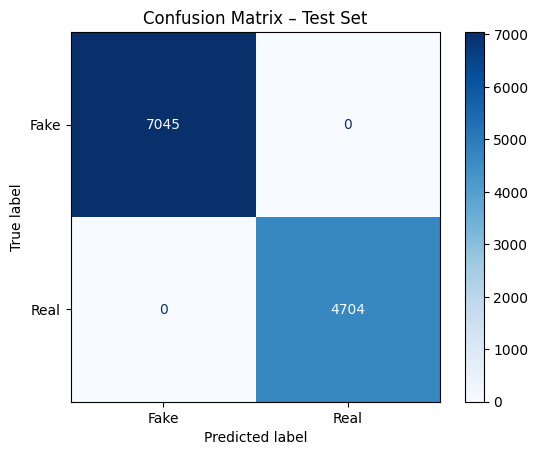

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Run prediction
pred = trainer.predict(tokenized_dataset["test"])
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.show()



# Try out some examples!

In [ ]:
model_path = "/content/drive/MyDrive/fake-news-deberta-model/"

trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)



('/content/drive/MyDrive/fake-news-deberta-model/tokenizer_config.json',
 '/content/drive/MyDrive/fake-news-deberta-model/special_tokens_map.json',
 '/content/drive/MyDrive/fake-news-deberta-model/spm.model',
 '/content/drive/MyDrive/fake-news-deberta-model/added_tokens.json',
 '/content/drive/MyDrive/fake-news-deberta-model/tokenizer.json')

In [ ]:
!ls -l "/content/drive/MyDrive/fake-news-deberta-model/"


total 731294
-rw------- 1 root root        23 Dec  3 21:38 added_tokens.json
-rw------- 1 root root       948 Dec  3 21:37 config.json
-rw------- 1 root root 737719272 Dec  3 21:38 model.safetensors
-rw------- 1 root root       286 Dec  3 21:38 special_tokens_map.json
-rw------- 1 root root   2464616 Dec  3 21:38 spm.model
-rw------- 1 root root      1315 Dec  3 21:38 tokenizer_config.json
-rw------- 1 root root   8656877 Dec  3 21:38 tokenizer.json


In [ ]:
import torch
from transformers import DebertaV2Tokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

model_path = "/content/drive/MyDrive/fake-news-deberta-model/"

# Load tokenizer manually (DeBERTa uses SentencePiece)
tokenizer = DebertaV2Tokenizer.from_pretrained(model_path)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Create pipeline manually
news_classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

print("Pipeline loaded successfully!")

# ---------------------------------------------------
# CONFIDENCE THRESHOLD FUNCTION
# ---------------------------------------------------
def classify_with_threshold(text, threshold=0.75):
    result = news_classifier(text)[0]
    label = result["label"]
    score = result["score"]

    if score < threshold:
        return {
            "label": "Uncertain – needs human review",
            "confidence": score
        }
    else:
        return {
            "label": label,
            "confidence": score
        }



Device set to use cuda:0


Pipeline loaded successfully!


In [ ]:
import torch
from transformers import DebertaV2Tokenizer, AutoModelForSequenceClassification

model_path = "/content/drive/MyDrive/fake-news-deberta-model/"

# Load tokenizer manually
tokenizer = DebertaV2Tokenizer.from_pretrained(model_path)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# TEST
text = "This is a real news example about government statistics."

inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs).logits

print(outputs)


tensor([[ 6.0549, -6.1961]], grad_fn=<AddmmBackward0>)


In [ ]:
fake_news_example = """
BREAKING: Scientists warn that the sun will explode next Friday unless
all citizens donate $50 immediately. Anonymous experts confirm the threat
but provide no scientific evidence. Social media influencers are urging
everyone to act fast before it's too late.
"""
#news_classifier(fake_news_example)
classify_with_threshold(fake_news_example)

{'label': 'Fake', 'confidence': 0.9999973773956299}

real news example

In [ ]:
real_news_example = """
The U.S. Department of Labor released updated employment numbers today,
showing moderate job growth in manufacturing and technology sectors.
Economists say the trend aligns with long-term projections for the year.
"""
#news_classifier(real_news_example)
classify_with_threshold(real_news_example)

{'label': 'Fake', 'confidence': 0.9999587535858154}

Save train model

In [ ]:
model.save_pretrained("/content/drive/MyDrive/fake-news-deberta-model/")
tokenizer.save_pretrained("/content/drive/MyDrive/fake-news-deberta-model/")




('/content/drive/MyDrive/fake-news-deberta-model/tokenizer_config.json',
 '/content/drive/MyDrive/fake-news-deberta-model/special_tokens_map.json',
 '/content/drive/MyDrive/fake-news-deberta-model/spm.model',
 '/content/drive/MyDrive/fake-news-deberta-model/added_tokens.json')

# Resources

### If you would like to use this model without running the entire notebook, try the model at my [HuggingFace](https://huggingface.co/wesleyacheng/movie-review-sentiment-classifier-with-bert).

### If you woud like to get this in GitHub, here's my [repo](https://github.com/wesleyacheng/movie-review-sentiment-classifier-with-bert).

In [ ]:
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification

model_path = "/content/drive/MyDrive/fake-news-deberta-model/"

tokenizer = DebertaV2Tokenizer.from_pretrained(model_path)
model = DebertaV2ForSequenceClassification.from_pretrained(model_path)

print("Loaded successfully!")


Loaded successfully!


In [ ]:
import pandas as pd
from datasets import Dataset
import re

# ---------------------------
# 1. Load your REAL and FAKE data
# ---------------------------
df_real = pd.read_excel("/content/drive/MyDrive/TrueDataset.xlsx")
df_fake = pd.read_excel("/content/drive/MyDrive/MyFakeDataset reformatted.xlsx")

df_real.columns = df_real.columns.str.lower().str.strip()
df_fake.columns = df_fake.columns.str.lower().str.strip()

df_real["label"] = 1
df_fake["label"] = 0

df_60 = pd.concat([df_real, df_fake], axis=0).reset_index(drop=True)

# ---------------------------
# 2. CLEANING FUNCTION
# ---------------------------
def clean_text(t):
    if not isinstance(t, str):
        return ""

    t = t.strip()

    # Remove metadata (timestamps, author lines)
    t = re.sub(r"^\s*(updated|published|by|copyright).*?\n", "", t, flags=re.I)

    # Replace multiple whitespace with one space
    t = re.sub(r"\s+", " ", t)

    return t

df_60["text"] = df_60["text"].apply(clean_text)

# Remove extremely short texts (<30 chars)
df_60 = df_60[df_60["text"].str.len() > 30].reset_index(drop=True)

print("Final total test samples after cleaning:", len(df_60))

# ---------------------------------------------------------
# 🔥 ADD PLACEHOLDER COLUMNS HERE (IMPORTANT!)
# ---------------------------------------------------------
df_60["title"] = ""
df_60["subject"] = ""
df_60["date"] = ""

# ---------------------------
# 3. Convert to HF Dataset
# ---------------------------
final_test_dataset = Dataset.from_pandas(df_60)

# ---------------------------
# 4. Tokenize (same settings as training)
# ---------------------------
def tokenize(batch):
    combined_texts = []

    for sub, title, text in zip(batch["subject"], batch["title"], batch["text"]):
        # Ensure strings
        s = sub if isinstance(sub, str) else ""
        t = title if isinstance(title, str) else ""
        x = text if isinstance(text, str) else ""

        combined = f"{s} {t} {x}".strip()
        combined_texts.append(combined)

    return tokenizer(
        combined_texts,
        truncation=True,
        padding="max_length",
        max_length=256
    )


tokenized_final_test = final_test_dataset.map(tokenize, batched=True)
print("Tokenization complete.")




Final total test samples after cleaning: 58


Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Tokenization complete.


In [ ]:
!pip install evaluate --quiet


In [ ]:
from transformers import TrainingArguments, Trainer

training_args_eval = TrainingArguments(
    output_dir="./results_eval",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer_eval = Trainer(
    model=model,
    args=training_args_eval,
    eval_dataset=tokenized_final_test,
    compute_metrics=compute_metrics
)

Valid predictions after threshold: 58
              precision    recall  f1-score   support

        Fake       0.52      1.00      0.68        29
        Real       1.00      0.07      0.13        29

    accuracy                           0.53        58
   macro avg       0.76      0.53      0.41        58
weighted avg       0.76      0.53      0.41        58



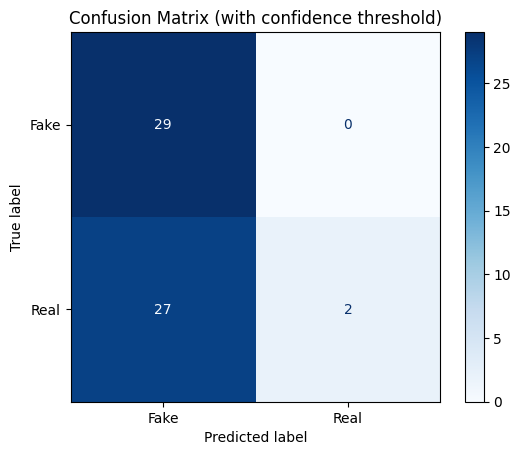

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def predict_with_threshold(logits, threshold=0.75):
    probs = torch.softmax(torch.tensor(logits), dim=-1)
    confs, preds = torch.max(probs, dim=-1)

    final_preds = []
    for p, c in zip(preds, confs):
        if c < threshold:
            final_preds.append(-1)  # label for "uncertain"
        else:
            final_preds.append(p.item())
    return final_preds, confs.numpy()

# Run original predictions
pred = trainer_eval.predict(tokenized_final_test)

logits = pred.predictions
y_true = pred.label_ids

y_pred_threshold, confs = predict_with_threshold(logits)

# Filter out uncertain
valid_idx = [i for i, p in enumerate(y_pred_threshold) if p != -1]

y_true_valid = y_true[valid_idx]
y_pred_valid = [y_pred_threshold[i] for i in valid_idx]

print("Valid predictions after threshold:", len(valid_idx))

print(classification_report(y_true_valid, y_pred_valid, target_names=["Fake","Real"]))

cm = confusion_matrix(y_true_valid, y_pred_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake","Real"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (with confidence threshold)")
plt.show()


In [ ]:
print("Evaluating on the 60-article custom dataset...")
eval_results = trainer_eval.evaluate()
eval_results


Evaluating on the 60-article custom dataset...


{'eval_loss': 5.988384246826172,
 'eval_model_preparation_time': 0.0026,
 'eval_accuracy': 0.5344827586206896,
 'eval_f1': 0.12903225806451613,
 'eval_runtime': 1.0899,
 'eval_samples_per_second': 53.216,
 'eval_steps_per_second': 3.67}

Total misclassified samples: 27 out of 58
Accuracy estimate: 0.5344827586206897

---- MISCLASSIFIED EXAMPLE 0 ----
TRUE LABEL: 1
PREDICTED LABEL: 0
TEXT (first 500 chars):
Bear encounters on the rise in B.C. community where grizzlies attacked school group, residents say Bear population in Bella Coola region has increased, residents say As B.C. conservation officers continued to search for the three grizzlies involved in Thursday’s attack on an elementary school group in Bella Coola, residents say the incident reflects years of rising bear encounters in the remote Central Coast community. At a news conference Sunday, Sgt. Jeff Tyre with the B.C. Conservation Office 


---- MISCLASSIFIED EXAMPLE 1 ----
TRUE LABEL: 1
PREDICTED LABEL: 0
TEXT (first 500 chars):
X's new location feature exposes apparent fraudster accounts posing as Americans, Gaza journalists A new feature on Elon Musk's X is exposing the truth behind social media accounts across the political spectrum, with account owners a

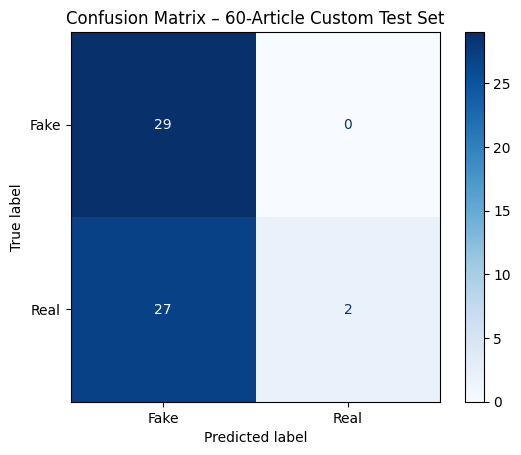

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict
pred = trainer_eval.predict(tokenized_final_test)

# True and predicted labels
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

wrong_indices = np.where(y_pred != y_true)[0]

print("Total misclassified samples:", len(wrong_indices), "out of", len(y_true))
print("Accuracy estimate:", (1 - len(wrong_indices) / len(y_true)))

# Show the first 5 misclassified examples
for idx in wrong_indices[:5]:
    print("\n---- MISCLASSIFIED EXAMPLE", idx, "----")
    print("TRUE LABEL:", y_true[idx])
    print("PREDICTED LABEL:", y_pred[idx])
    print("TEXT (first 500 chars):")
    print(df_60.iloc[idx]["text"][:500], "\n")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])

# Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – 60-Article Custom Test Set")
plt.show()


In [ ]:
from transformers import DebertaV2Tokenizer, AutoModelForSequenceClassification
import torch

model_path = "/content/drive/MyDrive/fake-news-deberta-model/"

# Force-load tokenizer manually (bypasses broken tokenizer_config.json)
tokenizer = DebertaV2Tokenizer.from_pretrained(
    model_path,
    vocab_file=model_path + "spm.model",
    tokenizer_file=model_path + "tokenizer.json",
    trust_remote_code=True
)

# Load model normally
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    trust_remote_code=True
)

# Test
text = "This is a real news example about government statistics."
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs).logits
print(outputs)


tensor([[ 6.0549, -6.1961]], grad_fn=<AddmmBackward0>)
